<a href="https://colab.research.google.com/github/03-hub/ThinkStats2/blob/master/Copy_of_SemEvaltask1_submission_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREDICTING CONTRIBUTION SENTENCES USING LSTM MODEL

In [ ]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)  
#(function) mount: (mountpoint, force_remount=False, timeout_ms=120000) -> None

#Mount your Google Drive at the specified mountpoint path.

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ncg-task/training-data.git "/content/train"


Cloning into '/content/train'...
remote: Enumerating objects: 6864, done.
remote: Counting objects: 100% (3083/3083), done.
remote: Compressing objects: 100% (2728/2728), done.
remote: Total 6864 (delta 567), reused 2504 (delta 279), pack-reused 3781
Receiving objects: 100% (6864/6864), 157.36 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (660/660), done.
Checking out files: 100% (3286/3286), done.


IMPORTING REQUIRED LIBRARIES

In [ ]:
import os
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertConfig, BertTokenizerFast, TFBertForSequenceClassification
EPOCHS = 3#I choosed 3 epochs i.e;my training dataset passes through lstm model 3 times
BATCH_SIZE = 8#I use 8 training examples in one iteration


     |████████████████████████████████| 4.2 MB 11.7 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 6.6 MB 85.7 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def Articlesandcontributions(path):
    articles = []
    contributions = []

    for task_name in os.listdir(path):  #/training-data
        if task_name != 'README.md' and task_name != '.git':
          article_category = os.path.join(path, task_name)  # ./training-data/natural_language_inference

          for folder_name in sorted(os.listdir(article_category)):
            #os.listdir(path=None)

#             Return a list containing the names of the files in the directory.

#             path can be specified as either str, bytes, or a path-like object.  If path is bytes,
#             the filenames returned will also be bytes; in all other circumstances
#             the filenames returned will be str.
#             If path is None, uses the path='.'.
              article_index = os.path.join(article_category, folder_name)  # ./datasets/training-data/natural_language_inference/0
#             os.path.join(a,*p)

#              Join two or more pathname components, inserting '/' as needed.
#              If any component is an absolute path, all previous path components
#              will be discarded.  An empty last part will result in a path that
#              ends with a separator.
              with open(glob.glob(os.path.join(article_index, '*-Stanza-out.txt'))[0], encoding='utf-8') as f:#I used glob to retrieve files with matching pattern
                  article = f.read()                                                                           #* wild card matches the files with stanze out.txt
                  articles.append(article.lower())
                
              with open(os.path.join(article_index, 'sentences.txt'), encoding='utf-8') as f:
                  contribution = []
                  for line in f.readlines():
                      article_contribution = int(line.strip())
                      contribution.append(article_contribution)
                  contributions.append(contribution) #contribution=[99,10.....]
          #     break
          # break
    return articles, contributions

In [ ]:
def SentenceAndLables(articles, contributions):
    sentences = []
    labels = []
    for i, article in enumerate(articles):
#enumerate(*args, **kwargs)

# Return an enumerate object.

# iterable
#   an object supporting iteration

#The enumerate object yields pairs containing a count (from start, which
#defaults to zero) and a value yielded by the iterable argument.

#enumerate is useful for obtaining an indexed list:
#   (0, seq[0]), (1, seq[1]), (2, seq[2]), ...

        contribution = contributions[i]

        sents = article.split('\n')[0:-1]

        for j, sent in enumerate(sents):
            sentences.append(sent)
            if (j + 1) in contribution:
                labels.append(1)
            else:
                labels.append(0)
    return sentences, labels


In [ ]:
train_input_dir='/content/train'

In [ ]:

train_articles, train_contributions = Articlesandcontributions(train_input_dir)

train_sentences, train_labels = SentenceAndLables(train_articles, train_contributions)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(train_sentences, train_labels, test_size=.2)
#def train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

#Split arrays or matrices into random train and test subsets.

#list: train_sentences
#(44160 items) ['experiments show an ...', 'this assumption may.]

#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

PREPROCESSING

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
#def __init__(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0, **kwargs)

#Text tokenization utility class.
#This class allows to vectorize a text corpus, by turning each
#text into either a sequence of integers (each integer being the index
#of a token in a dictionary) or into a vector where the coefficient
#for each token could be binary, based on word count, based on tf-idf..

tok.fit_on_texts(train_sentences)
#(method) fit_on_texts: (texts) -> None
#Updates internal vocabulary based on a list of texts.

sequences = tok.texts_to_sequences(train_sentences)
#(method) texts_to_sequences: (texts) -> list[list]
#Transforms each text in texts to a sequence of integers.
#Only top num_words-1 most frequent words will be taken into account.
#Only words known by the tokenizer will be taken into account.

sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
#def pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
#Pads sequences to the same length.
#This function transforms a list (of length num_samples)
#of sequences (lists of integers)
#into a 2D Numpy array of shape (num_samples, num_timesteps).
#num_timesteps is either the maxlen argument if provided,
#or the length of the longest sequence in the list.


tok.fit_on_texts(test_sentences)

t_sequences = tok.texts_to_sequences(test_sentences)

t_sequences_matrix = sequence.pad_sequences(t_sequences,maxlen=max_len)

CREATING MODEL

In [ ]:
def NN():
    inputs = Input(name='inputs',shape=[max_len])

    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    #def __init__(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs)

    #Turns positive integers (indexes) into dense vectors of fixed size.
    #e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

    layer = LSTM(64)(layer)
    #def __init__(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, 
    #return_sequences=False, return_state=False, go_backwards=False, stateful=False, time_major=False, unroll=False, **kwargs)
    #LSTM(64) reduces the feature size to 64.Since,return_sequences=False,it outputs a feature vector of size 1*64

    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    #def __init__(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)

    #Dense implements the operation:
    #output = activation(dot(input, kernel) + bias)
    #where activation is the element-wise activation function
    #passed as the activation argument

    layer = Dense(128)(layer)
    layer=Activation('relu')(layer)

    layer = Dropout(0.1)(layer)
    #def def __init__(rate, noise_shape=None, seed=None, **kwargs)
    #Applies Dropout to the input.
    #The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 
    #are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=inputs,outputs=layer)
    #Model groups layers into an object with training and inference features.
    return model

In [ ]:
model=NN()

model.summary()

model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

#Loss function says how good our model is in prediction.
#Binary crossentropy is the negative average of the log of corrected predicted probabilities.It compares each of the predicted probabilities to actual
#class output which can be either 0 or 1

#Adam is an algorithm for gradient based stochastic objective functions.It combines the advantages of two SGD extensions-RMSpROP and AdaGrad.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 activation_1 (Activation)   (None, 128)               0     

TRAINING THE MODEL

In [ ]:
import numpy as np

sequences_matrix=np.array(sequences_matrix) #Converting 2D matrix to 1D array
train_labels=np.array(train_labels)         #Converting list to 1D array

history=model.fit(sequences_matrix,train_labels,batch_size=128,epochs=10)


Epoch 1/10
345/345 [==============================] - 46s 134ms/step - loss: 0.0570 - accuracy: 0.9779
Epoch 2/10
345/345 [==============================] - 47s 136ms/step - loss: 0.0543 - accuracy: 0.9794
Epoch 3/10
345/345 [==============================] - 47s 136ms/step - loss: 0.0487 - accuracy: 0.9807
Epoch 4/10
345/345 [==============================] - 48s 138ms/step - loss: 0.0459 - accuracy: 0.9822
Epoch 5/10
345/345 [==============================] - 46s 135ms/step - loss: 0.0453 - accuracy: 0.9829
Epoch 6/10
345/345 [==============================] - 45s 131ms/step - loss: 0.0435 - accuracy: 0.9838
Epoch 7/10
345/345 [==============================] - 45s 130ms/step - loss: 0.0374 - accuracy: 0.9861
Epoch 8/10
345/345 [==============================] - 45s 129ms/step - loss: 0.0365 - accuracy: 0.9865
Epoch 9/10
345/345 [==============================] - 44s 128ms/step - loss: 0.0391 - accuracy: 0.9853
Epoch 10/10
345/345 [==============================] - 48s 140ms/step - l

1380/1380 [==============================] - 28s 20ms/step - loss: 0.0263 - accuracy: 0.9911


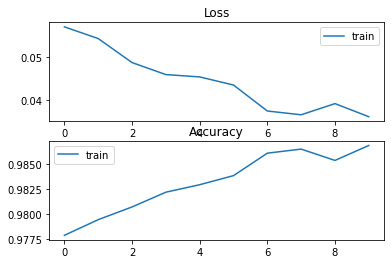

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score

test_matrix=np.array(t_sequences_matrix)
test_labels=np.array(test_labels)
test_acc = model.evaluate(test_matrix,test_labels)
train_acc=model.evaluate(sequences_matrix,train_labels)

# (method) evaluate: (x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, return_dict=False, **kwargs) -> (Any | list)

#Returns the loss value & metrics values for the model in test mode.
#Computation is done in batches (see the batch_size arg.)
#Args:
#   x: Input data. It could be:
#    A Numpy array (or array-like), or a list of arrays
#    (in case the model has multiple inputs).
#plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'],label='train')
plt.legend()

#plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='train')
plt.legend()
plt.show()



EVALUATING ON TEST MATRIX

In [ ]:
y_probs=model.predict(test_matrix,verbose=0)
y_probs=y_probs[:,0]

accuracy=accuracy_score(test_labels,y_probs.round())
print('accuracy: %f' % accuracy)
#(y_true, y_pred, *, beta=1, labels=None, pos_label=1, average=None, warn_for=("precision", "recall", "f-score"), sample_weight=None, zero_division="warn") 
#-> (tuple[float64, float64, float64, None] | tuple[Any, Any, Any, ndarray | Any | None])
precision=precision_score(test_labels,y_probs.round())
print('Precision: %f' % precision)
#Compute precision, recall, F-measure and support for each class.

#The precision is the ratio tp / (tp + fp) where tp is the number of
#true positives and fp the number of false positives. The precision is
#intuitively the ability of the classifier not to label as positive a sample
#that is negative
recall=recall_score(test_labels,y_probs.round())
print('Recall; %f'%recall)

f1=f1_score(test_labels,y_probs.round())
print('F1 Score; %f' % f1)

cm=confusion_matrix(test_labels,y_probs.round())
print(cm)

accuracy: 0.848202
Precision: 0.122673
Recall; 0.113475
F1 Score; 0.117895
[[9253  801]
 [ 875  112]]
